In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN.tmpUtils import *
import rpy2.robjects as robj
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import lfilter, firls, decimate
%matplotlib inline

In [3]:
robj.r.source("../Rcode/utils.R")
RsegCorr = robj.r["segCorr"]
RsegPCA = robj.r["segPCA"]
RsegDMD = robj.r["DMD"]
RchgF = robj.r["chgF"]
RsegDMDOrg = robj.r["DMDOrg"]
RsegPCAOrg = robj.r["segPCAOrg"]

###  Load data and ground truth

In [5]:
resDir = Path("../results")
dataDir = Path("../data/MEG-eye-unfiltering-0203")
datFil = list(dataDir.glob("*02*min.mat"))[0]
gtF = list(dataDir.glob("*02_st.txt"))[0]
gtSt02 = time2pts(txt2Time(gtF), timeLims.st02)
print(datFil)
print(np.diff(gtSt02.cpts))
gtSt02.cpts

../data/MEG-eye-unfiltering-0203/lcmv_result_R2868E_02-st_wo_filtering_min.mat
[1034 1345 1392 1253 1365]


array([ 535, 1569, 2914, 4306, 5559, 6924])

In [6]:
# The time course is 60 seconds, so the frequency is 1200 Hz
MEG = loadmat(datFil)
data = MEG["DK_timecourse"]

###  Data preprocessing

In [7]:
q = 10
dataN = decimate(data, q=q)
dataN = detrend(dataN)

### HPF 

In [8]:
fs = 120 #sampling frequency
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
hbp = firls(101, np.array([0, 0.2*fmin, 0.9*fmin, fmax-2, fmax+5, 60])*2/fs,
           desired = np.array([0, 0, 1, 1, 0, 0])) #for detrending, a bandpass
dataHPF = lfilter(hbp, 1, dataN)

In [9]:
ecptss = edict()

In [10]:
d, n = dataN.shape

paras = edict()
paras.rank = 12 
paras.slidew = 40

In [11]:
ecpts = edict()

paras.wsize = 200
paras.seqw = np.arange(1, n-paras.wsize, paras.slidew)
rSeqw = py2Rvec(paras.seqw)
rYmat = py2Rmat(dataN)

# Detection results for DCOR
rDCORres = RsegCorr(rYmat, paras.wsize, rSeqw)
rDCORecpts = RchgF(rDCORres, rSeqw)
ecpts.DCOR = np.array(rDCORecpts)
    
# Detection results for PCA
rPCAres = RsegPCA(rYmat, paras.wsize, rSeqw, rank=paras.rank)
rPCAecpts = RchgF(rPCAres, rSeqw)
ecpts.PCA = np.array(rPCAecpts)
    
# Detection results for DMD
rDMDres = RsegDMD(rYmat, paras.wsize, rSeqw, rank=paras.rank)
rDMDecpts = RchgF(rDMDres, rSeqw)
ecpts.DMD = np.array(rDMDecpts)

ecptss[f'w{paras.wsize}'] = ecpts

In [12]:
ecpts = edict()

paras.wsize = 400
paras.seqw = np.arange(1, n-paras.wsize, paras.slidew)
rSeqw = py2Rvec(paras.seqw)
rYmat = py2Rmat(dataN)

# Detection results for DCOR
rDCORres = RsegCorr(rYmat, paras.wsize, rSeqw)
rDCORecpts = RchgF(rDCORres, rSeqw)
ecpts.DCOR = np.array(rDCORecpts)
    
# Detection results for PCA
rPCAres = RsegPCA(rYmat, paras.wsize, rSeqw, rank=paras.rank)
rPCAecpts = RchgF(rPCAres, rSeqw)
ecpts.PCA = np.array(rPCAecpts)
    
# Detection results for DMD
rDMDres = RsegDMD(rYmat, paras.wsize, rSeqw, rank=paras.rank)
rDMDecpts = RchgF(rDMDres, rSeqw)
ecpts.DMD = np.array(rDMDecpts)

ecptss[f'w{paras.wsize}'] = ecpts

In [13]:
ecpts = edict()

paras.wsize = 600
paras.seqw = np.arange(1, n-paras.wsize, paras.slidew)
rSeqw = py2Rvec(paras.seqw)
rYmat = py2Rmat(dataN)

# Detection results for DCOR
rDCORres = RsegCorr(rYmat, paras.wsize, rSeqw)
rDCORecpts = RchgF(rDCORres, rSeqw)
ecpts.DCOR = np.array(rDCORecpts)
    
# Detection results for PCA
rPCAres = RsegPCA(rYmat, paras.wsize, rSeqw, rank=paras.rank)
rPCAecpts = RchgF(rPCAres, rSeqw)
ecpts.PCA = np.array(rPCAecpts)
    
# Detection results for DMD
rDMDres = RsegDMD(rYmat, paras.wsize, rSeqw, rank=paras.rank)
rDMDecpts = RchgF(rDMDres, rSeqw)
ecpts.DMD = np.array(rDMDecpts)

ecptss[f'w{paras.wsize}'] = ecpts

In [14]:
ecpts = edict()

paras.wsize = 800
paras.seqw = np.arange(1, n-paras.wsize, paras.slidew)
rSeqw = py2Rvec(paras.seqw)
rYmat = py2Rmat(dataN)

# Detection results for DCOR
rDCORres = RsegCorr(rYmat, paras.wsize, rSeqw)
rDCORecpts = RchgF(rDCORres, rSeqw)
ecpts.DCOR = np.array(rDCORecpts)
    
# Detection results for PCA
rPCAres = RsegPCA(rYmat, paras.wsize, rSeqw, rank=paras.rank)
rPCAecpts = RchgF(rPCAres, rSeqw)
ecpts.PCA = np.array(rPCAecpts)
    
# Detection results for DMD
rDMDres = RsegDMD(rYmat, paras.wsize, rSeqw, rank=paras.rank)
rDMDecpts = RchgF(rDMDres, rSeqw)
ecpts.DMD = np.array(rDMDecpts)

ecptss[f'w{paras.wsize}'] = ecpts

In [15]:
ecpts = edict()

paras.wsize = 1000
paras.seqw = np.arange(1, n-paras.wsize, paras.slidew)
rSeqw = py2Rvec(paras.seqw)
rYmat = py2Rmat(dataN)


# Detection results for DCOR
rDCORres = RsegCorr(rYmat, paras.wsize, rSeqw)
rDCORecpts = RchgF(rDCORres, rSeqw)
ecpts.DCOR = np.array(rDCORecpts)
    
# Detection results for PCA
rPCAres = RsegPCA(rYmat, paras.wsize, rSeqw, rank=paras.rank)
rPCAecpts = RchgF(rPCAres, rSeqw)
ecpts.PCA = np.array(rPCAecpts)
    
# Detection results for DMD
rDMDres = RsegDMD(rYmat, paras.wsize, rSeqw, rank=paras.rank)
rDMDecpts = RchgF(rDMDres, rSeqw)
ecpts.DMD = np.array(rDMDecpts)

ecptss[f'w{paras.wsize}'] = ecpts

###  Plot the results

In [16]:
ptime = np.linspace(0, 60, n)
ajfct = n/60
names = ["DCOR", "PCA", "DMD"]
ws = [200, 400, 600, 800, 1000]

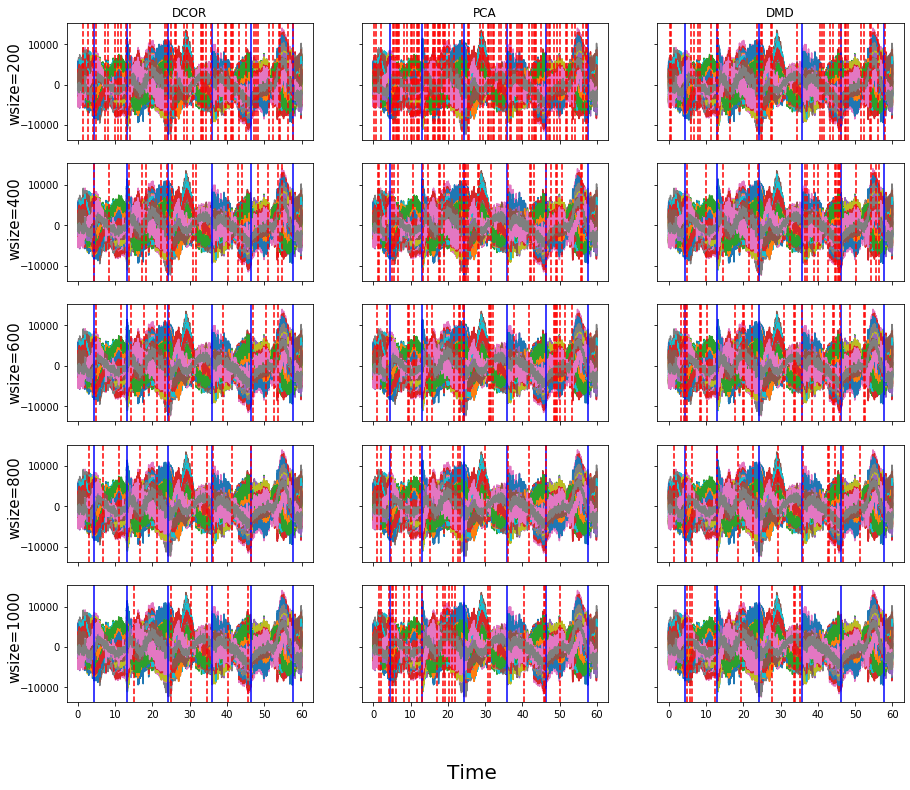

In [17]:
fig, axs= plt.subplots(nrows=5, ncols=3, sharex=True, sharey=True, figsize=(15, 12.5))

for fi in range(5):
    for fj in range(3):
        for i in range(d):
            axs[fi, fj].plot(ptime, dataN[i, :])
        for cpt in gtSt02.cpts:
            axs[fi, fj].axvline(cpt/ajfct, color="blue", linestyle="-")
        for ecpt in ecptss[f"w{ws[fi]}"][names[fj]]:
            axs[fi, fj].axvline(ecpt/ajfct, color="red", linestyle="--")
            
axs[0, 0].set_title("DCOR")
axs[0, 1].set_title("PCA")
axs[0, 2].set_title("DMD")


fig.text(0.5, 0.04, 'Time', ha='center', fontsize=20)
#fig.text(0.04, 0.5, 'Time', va='center', rotation="vertical", fontsize=20)
#
fig.text(0.07, 0.77, f"wsize={ws[0]}", rotation="vertical", fontsize=15)
fig.text(0.07, 0.62, f"wsize={ws[1]}", rotation="vertical", fontsize=15)
fig.text(0.07, 0.46, f"wsize={ws[2]}", rotation="vertical", fontsize=15)
fig.text(0.07, 0.31, f"wsize={ws[3]}", rotation="vertical", fontsize=15)
_ = fig.text(0.07, 0.15, f"wsize={ws[4]}", rotation="vertical", fontsize=15)